```{toctree}
:caption: Deltakit Textbook
:hidden:
:maxdepth: 1
About this textbook <notebooks/about-this-textbook>
Lessons from classical error correction <notebooks/classical-intuition>
Correctable errors <notebooks/correctable-errors>
Bit-flip repetition codes from scratch <notebooks/bit-flip-repetition-codes>
Phase-flip repetition codes from scratch <notebooks/phase-flip-repetition-codes>
Running fast circuit simulations <notebooks/running-faster-circuit-simulations>
Shor's 9-qubit code <notebooks/shor-code>
Decoder library <notebooks/decoder-library>
```

# Deltakit Textbook
Welcome! The Deltakit Textbook aims to be a hands-on introduction to quantum error correction concepts coupled with practical examples for exploring error-correcting codes. Written by the __[Riverlane](https://riverlane.com)__ team and friends.

In [1]:
import numpy as np
import matplotlib.pyplot as plotter
# plotter.rcParams['font.family'] = 'Monospace'
import holoviews as hv
from holoviews import opts
import warnings; warnings.filterwarnings('ignore')
import panel as pn
from tqdm import tqdm
try:
    import mlx.core as mx  # Apple's MLX library for Apple Silicon
except ImportError:
    raise RuntimeError("MLX not available. Uncomment the raw numbers to make the plot.")

In [2]:
def simulate_classical_rep_codes_with_gpu_mlx(distance, error_probability, n_shots):

    total_logical_errors = 0
    batch_size = min(int(500_000_000 * 1.), n_shots)  # Process 500M at a time on GPU
    
    shots_processed = 0
    while shots_processed < n_shots:
        current_batch = min(batch_size, n_shots - shots_processed)
        
        # Generate random desired messages for this batch in GPU
        desired_messages = mx.random.randint(low = 0, high = 2, shape=(current_batch,))
        
        # Encode: replicate each bit distance times in GPU
        encoded_messages = mx.repeat(desired_messages[:, mx.newaxis], distance, axis=1)

        # Send: simulate bit flip errors
        error_mask = mx.random.uniform(low = 0, high = 1, shape=(current_batch, distance)) <= error_probability
        sent_messages = encoded_messages ^ error_mask
        
        # Receive and interpret: majority voting
        received_messages = mx.sum(sent_messages, axis=1) > (distance // 2)
                
        # Accumulate errors and bring them back to CPU
        total_logical_errors += int(mx.sum(received_messages != desired_messages))
        shots_processed += current_batch
            
    return total_logical_errors / (n_shots * 1.)

In [3]:
def get_all_code_distance_error_probabilities(code_distances, p_errors, n_shots = int(1e5)):

    all_code_distance_error_probabilities = []
    for distance in code_distances:
        this_code_distance_error_probabilities = []
        for p_error in tqdm(p_errors):
            this_code_distance_error_probabilities.append(
                            simulate_classical_rep_codes_with_gpu_mlx(
                            distance, p_error, n_shots
                            ))
        all_code_distance_error_probabilities.append(this_code_distance_error_probabilities)

    return all_code_distance_error_probabilities

In [4]:
# code_distances = np.arange(start=1, stop=13+1, step=2)  # [1, 3, 5, 7, 9, 11, 13]
# p_errors = np.logspace(start=-4, stop=0, num=20)
# n_shots = int(20e9)
 
# all_logical_errors = get_all_code_distance_error_probabilities(
#                                         code_distances = code_distances, 
#                                         p_errors = p_errors, 
#                                         n_shots = n_shots
#                                         )

In [5]:
code_distances = np.arange(start=1, stop=13+1, step=2)  # [1, 3, 5, 7, 9, 11, 13]
p_errors = np.logspace(start=-4, stop=0, num=20)
n_shots = int(20e9)

all_logical_errors = np.array([
[9.98658e-05,0.0001622452,0.00026362745,0.00042824465,0.0006949711,0.0011293672,0.001832927,0.0029756828,0.00483298795,0.0078474256,0.01274254065,0.020692267,0.0335968143,0.05455613395,0.08858471805,0.14384386975,0.23356963985,0.3792706048,0.61584862375,1.0],
 [3.16e-08,7.815e-08,2.086e-07,5.543e-07,1.44495e-06,3.80925e-06,1.009335e-05,2.653395e-05,6.980555e-05,0.0001838169,0.000483003,0.00126697785,0.0033109893,0.0086042983,0.02215198835,0.05612229765,0.138184406,0.3224239051,0.67066496785,1.0],
 [5e-11,5e-11,2.5e-10,7e-10,3e-09,1.27e-08,6.21e-08,2.633e-07,1.1164e-06,4.7742e-06,2.03122e-05,8.584965e-05,0.0003606729,0.00149394695,0.0060614667,0.0237129361,0.0869526594,0.28227525345,0.70956449185,1.0],
 [0.0,0.0,0.0,0.0,5e-11,0.0,3.5e-10,3.55e-09,1.83e-08,1.321e-07,8.9615e-07,6.10215e-06,4.104715e-05,0.00027122285,0.0017290775,0.0104069317,0.0563852906,0.2507697618,0.7402483224,1.0],
 [0.0,0.0,0.0,0.0,0.0,0.0,5e-11,0.0,2e-10,4.25e-09,4.095e-08,4.4495e-07,4.8327e-06,5.058045e-05,0.00050636495,0.0046716422,0.03723282475,0.2248085391,0.7656526207,1.0],
 [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1e-10,2.2e-09,3.32e-08,5.7705e-07,9.57245e-06,0.00015069965,0.00212901415,0.02488740735,0.2028033932,0.7872835466,1.0],
 [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2e-10,3.4e-09,7.05e-08,1.8456e-06,4.537795e-05,0.00098095945,0.0167868647,0.1838117115,0.80605446975,1.0]
])
# [03:01,  9.07s/it]
# [05:42, 17.15s/it]
# [07:51, 23.59s/it]
# [12:24, 37.21s/it]
# [16:08, 48.43s/it]
# [18:42, 56.13s/it]
# [21:21, 64.06s/it]

In [37]:
def error_probabilities_for_code_distance(code_distance):
    error_probabilities = all_logical_errors[code_distances.tolist().index(code_distance)]
    return hv.Curve((
        p_errors,
        error_probabilities 
    )).opts(
        xlabel="Per-bit error probability",
        ylabel="Message error probability",
        logx=True,
        logy=True,
        marker='.',
        ylim=(1e-9, 1.1),
        xlim=(1e-9, 1.1),
        backend_opts={"axes.patch.edgecolor": 'black',
                      "axes.patch.linewidth": 1},
        fig_size = 85,
        fontscale = 0.75,
        title = '',
        show_grid=True
    ) * hv.Curve((
        np.linspace(start = 1e-9, stop = 1.1, num = 30),
        np.linspace(start = 1e-9, stop = 1.1, num = 30)
    )).opts(
        opts.Curve(color='black', linewidth=1),
    ) * hv.Text(24e-8, 60e-8, 'y = x (no error correction)', rotation = 45, fontsize=6)

hv.extension('matplotlib', logo = False)
hv.output(widget_location='bottom')
plot_and_slider = hv.HoloMap(
    {
        code_distance: error_probabilities_for_code_distance(code_distance)
        for code_distance in code_distances
    },
    kdims=["Repetition Count (Code Distance)"],
)

```{raw} html
<style>
.explanation-text {
    font-size: 12px;
    line-height: 1.3;
    color: #333;
    padding-right: 5px;
    padding-top: 40px;
}
</style>
```

```{raw} html
<div style="display: flex; align-items: start; gap: 30px;">
    <div class="explanation-text" style="flex: 0 0 35%;">
        <p>Imagine a sender transmitting bits (0 or 1) to a receiver over a noisy channel where some bits get flipped. To correct errors, the sender repeats the message several times, and the receiver uses a majority vote to determine the original bit -- a simple error-correcting method called a repetition code. The interactive plot shows how increasing the repetition count sharply reduces misinterpretation when the per-bit error probability is low. Use the slider below the plot to change the repetition count and see this effect!</p>
        <p>Plot generated using 20 billion shots per point on an Apple M2 Max processor.</p>
    </div>
    <div style="flex: 1;", width="100px">
```

:HoloMap   [Repetition Count (Code Distance)]
   :Overlay
      .Curve.I  :Curve   [x]   (y)
      .Curve.II :Curve   [x]   (y)
      .Text.I   :Text   [x,y]
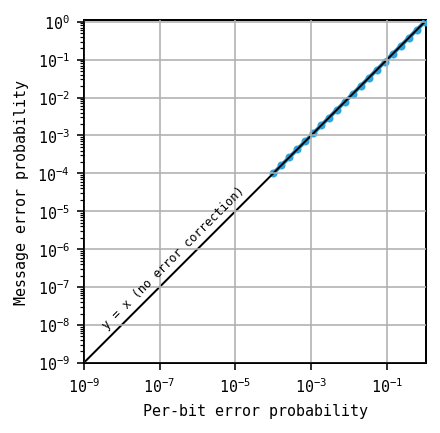
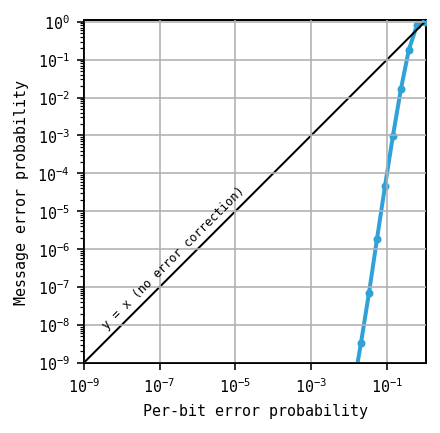
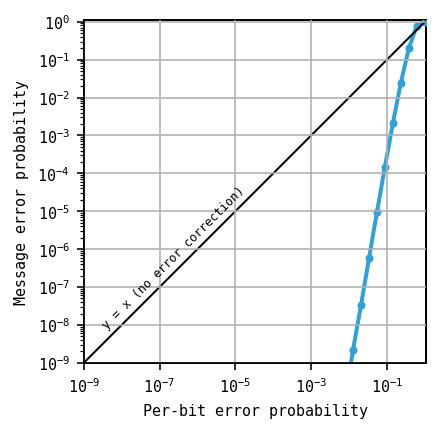
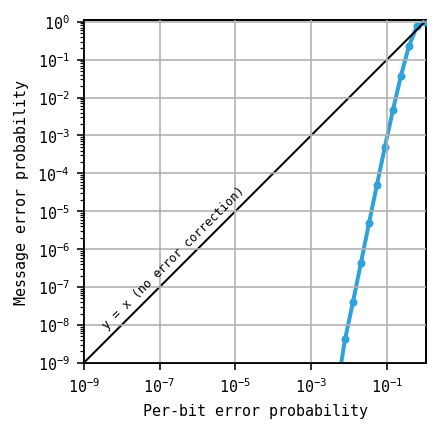
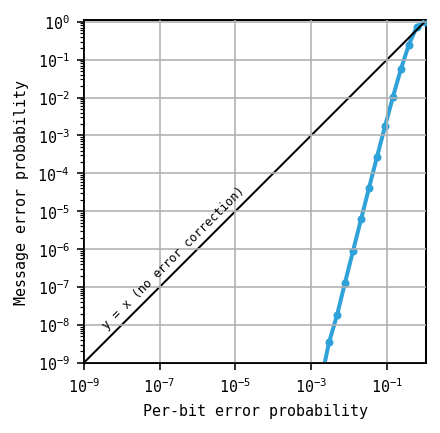
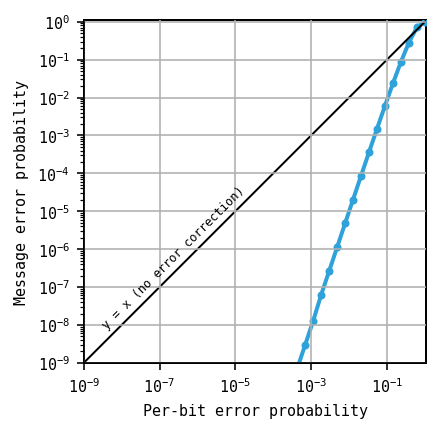
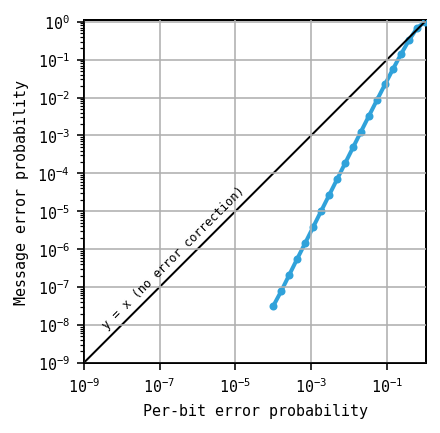
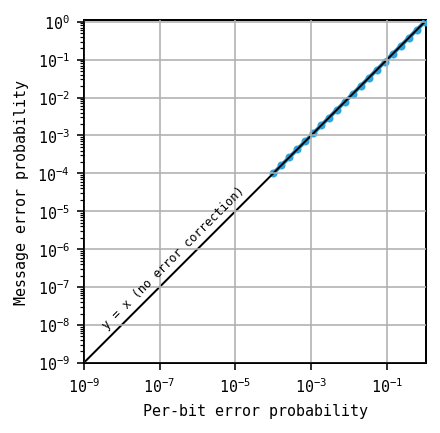

In [40]:
plot_and_slider

```{raw} html
    </div>
</div>
```

## Contents

### __About this textbook__
<ul>
  <li><a href="notebooks/about-this-textbook.html">About this textbook</a></li>
</ul>

### __Developing intuition for quantum error correction__
<ul>
  <li>Motivation for quantum error correction</li>
  <li><a href="notebooks/classical-intuition.html">Lessons from classical error correction</a></li>
  <li>Majority vote vs parity checks</li>
</ul>

### __From classical to quantum repetition codes__
<ul>
  <li><a href="notebooks/correctable-errors.html">Correctable errors</a></li>
  <li><a href="notebooks/bit-flip-repetition-codes.html">Building the bit-flip quantum repetition code from scratch</a></li>
  <li><a href="notebooks/phase-flip-repetition-codes.html">Retooling the bit-flip quantum repetition code to handle phase errors</a></li>
  <li><a href="notebooks/running-faster-circuit-simulations.html">Running faster circuit simulations</a></li>
  <li><a href="notebooks/shor-code.html">Combining bit-flip and phase-flip repetition codes: Shor's 9-qubit code</a></li>
</ul>

### __From repetition codes to surface codes__
<ul>
  <li>Introduction to surface codes</li>
    <li>Layout of unrotated surface code with stabilizers</li>
    <li>Syndrome extraction cycle with noise and logical operators</li>
    <li>Overview of the QEC cycle and introduction to Stim</li>
</ul>

### __Decoding surface codes__
<ul>
  <li>Introduction to minimum weight perfect matching</li>
  <li>Threshold theorem</li>
  <li>Simulating surface code in stim</li>
</ul>

### __Decoder library__
<ul>
  <li><a href="notebooks/decoder-library.html">Decoder library</a></li>
</ul>